## Apply PhyloVelo to clonal lineage tracing data - Larry

We now extend PhyloVelo to clonal lineage tracing data based on static barcodes such as lentiviral barcoding (e.g. LARRY and CellTagging) and T/B cell receptor sequences. Because the cell population size of a uniquely labelled clone at observation indicates its relative proliferation activity in the past division history, we thus used clone size as the surrogate of phylogenetic time in PhyloVelo.

Here is an example of using PhyloVelo to infer in vitro hematopoiesis differentiation.

In [10]:
import phylovelo as pv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scanpy as sc
import re
from collections import Counter

In [3]:
plt.rcParams['font.size'] = 12
color_map = {'Erythroid': '#b6c5e4',
 'Meg': '#9d48f1',
 'Ccr7_DC': '#e7893e',
 'Undifferentiated': '#4875ae',
 'Mast': '#80594f',
 'Baso': '#68bccb',
 'Monocyte': '#579b6e',
 'pDC': '#b5bd71',
 'Lymphoid': '#eeafaf',
 'Neutrophil': '#bd4038',
 'Eos': '#f4aeae'}
color_map_inv = {}
for key in color_map:
    color_map_inv[color_map[key]] = key
    
state_map = {0: 'Monocyte',
 1: 'Undifferentiated',
 2: 'Ccr7_DC',
 3: 'Baso',
 4: 'Erythroid',
 5: 'pDC',
 6: 'Lymphoid',
 7: 'Eos',
 8: 'Mast',
 9: 'Meg',
 10: 'Neutrophil'}

In [2]:
data = sc.read_loom('../../../demo/datasets/in_vitro_hematopoiesis/larry.loom')

In [6]:
clone_size = Counter(data.obs['Clone'])

In [8]:
selected_clones = np.array(list(clone_size.keys()))[(np.array(list(clone_size.values()))>1)&(np.array(list(clone_size.values()))<100)]
selected_cells = data.obs['Cell barcode'][np.isin(data.obs['Clone'], selected_clones)]
selected_data = data[selected_cells.index,]

In [11]:
sd = pv.scData(count=pd.DataFrame(data=selected_data.X.A, index=selected_data.obs_names, columns=selected_data.var_names),
                           Xdr=pd.DataFrame(data=selected_data.obs[['SPRING-x','SPRING-y']]),
                          )

In [12]:
sd.drop_duplicate_genes()
sd.normalize_filter(is_normalize=False, is_log=False, min_count=1, target_sum=None)
sd.x_normed = sd.count

In [13]:
#Filter out artificially inserted genes.
import re
drop_genes = []
for i in sd.x_normed.columns:
    for num in re.finditer('[0-9]+', i):
        if len(num.group(0)) > 4:
            drop_genes.append(i)
            continue
sd.x_normed = sd.x_normed[sd.x_normed.columns[~np.isin(sd.x_normed.columns, drop_genes)]]

In [14]:
clone_size = Counter(selected_data.obs['Clone'])
depths = [clone_size[i] for i in selected_data.obs['Clone']]

In [15]:
pv.velocity_inference(sd, np.round(np.log(depths), 1), cutoff=0.97)
pv.velocity_embedding(sd, target='x_normed', n_neigh=100)

  0%|          | 0/12879 [00:00<?, ?it/s]

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  0%|          | 0/1609 [00:00<?, ?it/s]

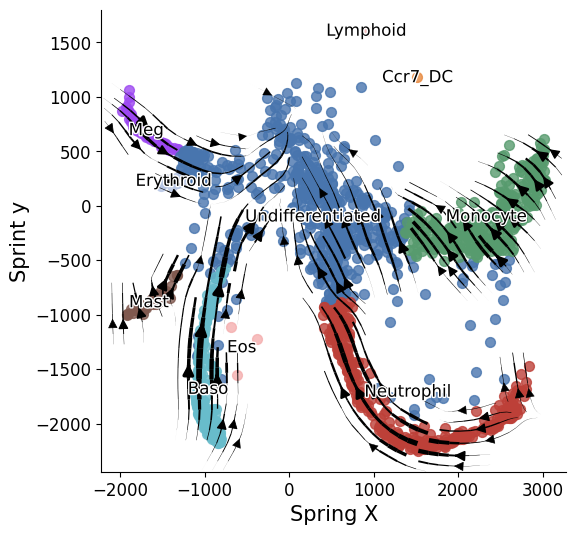

In [16]:
c = np.array(list((map(lambda x: color_map[x], selected_data.obs['Cell type annotation']))))
fig, ax = plt.subplots(figsize=(6, 6))
for i in color_map_inv.keys():
    ax.scatter(selected_data.obs['SPRING-x'][c==i], selected_data.obs['SPRING-y'][c==i], color=i, label=color_map_inv[i], alpha=0.8, s=50)
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=150, lw_coef=30, arrowsize=1.5)
pv.label_name(sd.Xdr.to_numpy(), selected_data.obs['Cell type annotation'], ax)
ax.set_xlabel('Spring X', fontsize=15)
ax.set_ylabel('Sprint y', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)